# Water consumption

The current notebook computes an interpolation of temperatures in each pixel based on SIAM extracted data.

A .bluemix/cos_credentials.json file correctly configured located at home directory is needed in order to connect with IBM Cloud. More information at https://cloud.ibm.com/docs/services/cloud-object-storage/iam?topic=cloud-object-storage-service-credentials.

In [2]:
from collections import defaultdict
from ibm_botocore.client import Config, ClientError
from io_utils.cos import COS
from io_utils.plot import plot_random_blocks, plot_results
from rasterio.windows import Window
from scipy.spatial import distance_matrix
from shapely.geometry import Point, MultiPoint, box

import os
import ibm_boto3
import math
import numpy as np
import pandas as pd
import lithops
import requests
import rasterio
import json

## Global parameters

Area outside the processed tile that we want to consider for taking SIAM stations into account:

In [3]:
AREA_OF_INFLUENCE = 4000

IBM Cos bucket to upload files:

In [4]:
BUCKET = 'aitor-us-south'

Split tile into SPLITS$^2$ chunks:

In [5]:
SPLITS = 3

Correlation coefficient between elevation and temperature:

In [6]:
r = -0.0056

Elevation to interpolate temperature:

In [7]:
zdet = 2000

Day of year to calculate solar irradiation:

In [8]:
DAY_OF_YEAR = 50

## Data preparation

Download SIAM data:

In [9]:
url = 'http://siam.imida.es/apex/f?p=101:47:493289053024037:CSV::::'
# url = 'http://siam.imida.es/apex/f?p=101:48:2555846978143339:CSV::::'
siam_data = requests.get(url)
with open('water/siam_data.csv', 'wb') as siam_data_file:
    siam_data_file.write(siam_data.content)

9165

In [10]:
def guess_nearest(x, y, field, stations):
    '''
    Compute field value at a given x,y point by getting the value of the closest station 
    '''
    from shapely.ops import nearest_points
    stations_of_interest = stations[(stations[field] != '-') & ((stations['X'] != x) | (stations['Y'] != y))]
    points = MultiPoint(stations_of_interest.apply(lambda row: Point(row['X'], row['Y']), axis=1 ).array)
    nearest = nearest_points(Point(x,y), points)[1]
    val = stations_of_interest[(stations_of_interest['X'] == nearest.x) &
                                (stations_of_interest['Y'] == nearest.y)]

    return stations_of_interest[(stations_of_interest['X'] == nearest.x) &
                                (stations_of_interest['Y'] == nearest.y)][field].iloc[0] 

Append locations of SIAM stations to previously downloaded data and write results to a CSV:

In [11]:
columns = {
    'Estación': 'COD',
    'Tmed <br> (ºC)': 'temp',
    'Hrmed <br> (%)': 'hr',
    'Vvmed <br> (m/seg)': 'v',
    'Eti.': 'dir',
    'Radmed <br> (w/m2)': 'rad',
    'Dvmed <br>  (º)': 'dir_deg'
}

siam_data = pd.read_csv('water/siam_data.csv', encoding='iso-8859-1', sep=';', decimal=',', thousands='.', na_values = '-')
siam_data = siam_data[columns.keys()].rename(columns=columns)
siam_locations = pd.read_csv('water/siam_locations.csv', encoding='iso-8859-1', sep=';', decimal = ',', thousands='.')
siam = pd.merge(siam_locations, siam_data, on='COD')
siam['tdet'] = siam['temp'] + r * (zdet - siam['Cota'].to_numpy())
siam = siam[['X', 'Y', 'Cota', 'temp', 'hr', 'tdet', 'v'] + list(columns.values())]
# Guess wind direction of undefined values
siam['dir_deg'] = siam.apply(lambda row: row['dir_deg'] 
                                     if not math.isnan(row['dir_deg'])
                                     else guess_nearest(row['X'], row['Y'], 'dir_deg', siam), axis=1)
# Guess radiation of undefined values
siam['rad'] = siam.apply(lambda row: row['rad'] 
                                     if not math.isnan(row['rad'])
                                     else guess_nearest(row['X'], row['Y'], 'rad', siam), axis=1)
siam.to_csv('water/siam_out.csv', index=False)

Upload the CSV written to IBM Cloud Object Storage:

In [12]:
with open(os.path.expanduser('~/.bluemix/cos_credentials.json')) as credentials_file:
    cos_credentials = json.loads(credentials_file.read())

cos = COS(ibm_api_key_id=cos_credentials['apikey'],
          ibm_service_instance_id=cos_credentials['resource_instance_id'],
          endpoint_url='https://s3.us-south.cloud-object-storage.appdomain.cloud',
          bucket=BUCKET)

In [13]:
cos.multi_part_upload('siam_out.csv', 'water/siam_out.csv')

cos.multi_part_upload('shapefile.zip', 'shapefiles/shapefile.zip')

Download MDT files for free from http://centrodedescargas.cnig.es/CentroDescargas/buscadorCatalogo.do?codFamilia=MDT05# and put them in `water/MDT` folder.

Find downloaded MDTs:

In [14]:
mdts = []
for root, dirs, files in os.walk("water/MDT"):
    for file in files:
        if file.endswith(".asc"):
             mdts.append(os.path.join(root, file))

Convert digital elevation map into a Cloud Optimized Geotiff. Upload then to IBM COS:

In [24]:
cos_mdts = []
cos_files = cos.get_cos_files()

for mdt in mdts:
    tiff_file = os.path.splitext(mdt)[0] + '.tif'
    file_name = tiff_file[tiff_file.rfind('/')+1:]
    if file_name not in cos_files:
        with rasterio.open(mdt) as src:
            profile = src.profile
            # Cloud optimized GeoTiff parameters (No hace falta rio_cogeo)
            profile.update(driver='GTiff')
            profile.update(blockxsize=256)
            profile.update(blockysize=256)
            profile.update(tiled=True)
            profile.update(compress='deflate')
            profile.update(interleave='band')
            with rasterio.open(tiff_file, "w", **profile) as dest:
                dest.write(src.read())
                
        cos.multi_part_upload(file_name, tiff_file)
    cos_mdts.append(file_name)

## Serverless computation

Compute solar irradiation given a day of year using GRASS libraries:

In [25]:
def compute_solar_irradiation(inputFile, outputFile, crs='32630'):

    # Define grass working set
    GRASS_GISDB = 'grassdata'
    GRASS_LOCATION = 'GEOPROCESSING'
    GRASS_MAPSET = 'PERMANENT'
    GRASS_ELEVATIONS_FILENAME = 'ELEVATIONS'
    
    import os
    import shutil
    os.environ['GRASSBIN'] = 'grass76'
    from grass_session import Session
    import grass.script as gscript
    from grass.pygrass.modules.shortcuts import general as g
    from grass.pygrass.modules.shortcuts import raster as r
    import re
    os.environ.update(dict(GRASS_COMPRESS_NULLS='1'))
    
    # Clean previously processed data
    if os.path.isdir(GRASS_GISDB):
        shutil.rmtree(GRASS_GISDB)
    with Session(gisdb=GRASS_GISDB, location=GRASS_LOCATION, mapset=GRASS_MAPSET, create_opts='EPSG:32630') as ses:
    
        # Set project projection to match elevation raster projection
        g.proj(epsg=crs, flags='c') 
    
        # Load raster file into working directory
        r.import_(input=inputFile, 
                  output=GRASS_ELEVATIONS_FILENAME, 
                  flags='o')    
        
        # Set project region to match raster region
        g.region(raster=GRASS_ELEVATIONS_FILENAME, flags='s')    
        # Calculate solar irradiation
        gscript.run_command('r.slope.aspect', elevation=GRASS_ELEVATIONS_FILENAME, slope='slope', aspect='aspect')
        gscript.run_command('r.sun', elevation=GRASS_ELEVATIONS_FILENAME, slope='slope', aspect='aspect', beam_rad='beam', step=1, day=DAY_OF_YEAR)
        
        # Get extraterrestrial irradiation from history metadata
        regex = re.compile(r'\d+\.\d+')
        output = gscript.read_command("r.info", flags="h", map=["beam"])
        splits = str(output).split('\n')
        line = next(filter(lambda line: 'Extraterrestrial' in line, splits))
        extraterrestrial_irradiance = float(regex.search(line)[0])
        
        # Export generated results into a GeoTiff file
        if os.path.isfile(outputFile):
            os.remove(outputFile)
            
        r.out_gdal(input='beam', output=outputFile)
        return extraterrestrial_irradiance

Get stations contained in the area of interest:

In [26]:
def filter_stations(bounds, stations):
    
    total_points = MultiPoint([Point(x,y) for x, y in stations[['X', 'Y']].to_numpy()])
    intersection = bounds.buffer(AREA_OF_INFLUENCE).intersection(total_points)
    return stations[[ intersection.contains(point) for point in total_points]]

Inverse Distance Weighting interpolation:

In [27]:
def compute_basic_interpolation(shape, stations, field_value='tdet', offset = (0,0)):
    
    station_pixels = [[pixel[0], pixel[1]] for pixel in stations['pixel'].to_numpy()]
    # Get an array where each position represents pixel coordinates
    tile_pixels = np.indices(shape).transpose(1,2,0).reshape(shape[0]*shape[1], 2) + offset
    dist = distance_matrix(station_pixels, tile_pixels)
    weights = np.where(dist == 0, np.finfo('float32').max, 1.0 / dist )
    weights /=  weights.sum(axis=0)
    return np.dot(weights.T, stations[field_value].to_numpy()).reshape(shape).astype('float32')

Compute interpolated temperature from selected stations:

In [28]:
def compute_interpolated_temperature(elevations, stations, zdet, r, offset = (0,0)):
    
    return compute_basic_interpolation(elevations.shape, stations, 'tdet', offset) + \
           r * (elevations - zdet) 

Interpolate temperatures from a subset of the tile:

In [29]:
def map_interpolation(obj, block_x, block_y, splits, output_type, ibm_cos):

    import io
    import math
    import numpy as np
    
    item = "tmp/" + obj.key[:obj.key.rfind('.')] + "_" + str(block_x) + "_" + str(block_y) + "_" + output_type + ".tif"
    if output_type == 'RADIATION':
        
        #with rasterio.open(obj.data_stream) as src:
        with rasterio.open(ibm_cos.get_object(Bucket=obj.bucket, Key=obj.key)['Body']) as src:
            transform = src.transform
            # Compute working window
            step_w = src.width/splits
            step_h = src.height/splits
            offset_h = round(step_h*block_x)
            offset_w = round(step_w*block_y)       
            profile = src.profile
            width = math.ceil(step_w*(block_y+1) - offset_w)
            height = math.ceil(step_h*(block_x+1) - offset_h)
            profile.update(width=width)
            profile.update(height=height)
            window = Window(offset_w,offset_h, width, height)
            with rasterio.open('input', "w", **profile) as dest:
                dest.write(src.read(window=window))
            # Stores global irradiation at "output", it also returns extraterrestrial irradiation
            extraterrestrial_irradiation = compute_solar_irradiation('input', 'output')
            # Create and store a raster with extraterrestrial_irradiation
            with rasterio.open('extr', "w", **profile) as dest:
                data = np.full((height, width), extraterrestrial_irradiation, dtype='float32')
                dest.write(data, 1)
            extr = "tmp/" + obj.key[:obj.key.rfind('.')] + "_" + str(block_x) + "_" + str(block_y) + "_EXTRAD.tif"
            ibm_cos.put_object(Bucket = obj.bucket, Key = extr, Body = open('extr', 'rb'))
    else:
        
        siam_stream = ibm_cos.get_object(Bucket=BUCKET, Key='siam_out.csv')['Body']
        siam = pd.read_csv(io.BytesIO(siam_stream.read()))
        with rasterio.open(ibm_cos.get_object(Bucket=obj.bucket, Key=obj.key)['Body']) as src:
            transform = src.transform
            # Compute working window
            step_w = src.width/splits
            step_h = src.height/splits
            offset_h = round(step_h*block_x)
            offset_w = round(step_w*block_y)       
            profile = src.profile
            width = math.ceil(step_w*(block_y+1) - offset_w)
            height = math.ceil(step_h*(block_x+1) - offset_h)
            profile.update(width=width)
            profile.update(height=height)
            window = Window(offset_w,offset_h, width, height)
            # Filter desired stations
            bounding_rect = box(src.bounds.left, src.bounds.top, src.bounds.right, src.bounds.bottom)
            filtered = pd.DataFrame(filter_stations(bounding_rect, siam))
            filtered['pixel'] = filtered.apply(lambda station: rasterio.transform.rowcol(transform, station['X'], station['Y']), axis=1)
            # Interpolate and write results 
            with rasterio.open('output', "w", **profile) as dest:

                if output_type == 'TEMPERATURE':
                    elevations = src.read(1, window=window) # Get elevations content
                    interpolation = compute_interpolated_temperature(elevations, filtered, zdet, r, (offset_h, offset_w))
                    dest.write(np.where(elevations == src.nodata, np.nan, interpolation), 1)
                else:
                    interpolation = compute_basic_interpolation((height, width), 
                                                                filtered, 
                                                                'hr' if output_type == 'HUMIDITY' else 'v', 
                                                                (offset_h, offset_w))
                    dest.write(interpolation, 1)

    # Export results to IBM_COS 
    ibm_cos.put_object(Bucket = obj.bucket, Key = item, Body = open('output', 'rb'))
    return (obj.key, width, height, output_type, block_x, block_y, item)

Lithops serverless computation:

In [30]:
iterdata = []
for cos_mdt in cos_mdts:
    for output_type in ['TEMPERATURE', 'HUMIDITY', 'WIND', 'RADIATION']:
        for i in range(0,SPLITS):
            for j in range(0,SPLITS):
                iterdata.append({
                    'obj': f'cos://{BUCKET}/{cos_mdt}', 
                    'block_x': j, 
                    'block_y': i, 
                    'splits': SPLITS, 
                    'output_type': output_type
                })
                
lith = lithops.FunctionExecutor(runtime='cloudbuttonans/geospatial-runtime:3.7-v6')
lith.map(map_interpolation, iterdata, timeout=600, runtime_memory=2048)
map_result = lith.get_result()

Lithops v2.2.3-SNAPSHOT init for IBM Cloud Functions - Namespace: cloudlab_urv_us_south - Region: us_south
ExecutorID 946f05/1 | JobID M000 - Selected Runtime: cloudbuttonans/geospatial-runtime:3.7-v6 - 2048MB 
ExecutorID 946f05/1 | JobID M000 - Uploading function and data - Total: 33.8KiB
0/|/ 0/108ExecutorID 946f05/1 | JobID M000 - Starting function invocation: map_interpolation() - Total: 108 activations
ExecutorID 946f05/1 - Getting results...
108/|/ 108/108ExecutorID 946f05/1 - Cleaning temporary data



Join split subsets into a tile:

In [31]:
def gather_blocks(tile, splits, width, height, output_type, objs, ibm_cos):

    from rasterio.windows import Window
    
    size = len(objs)
    item = tile[:tile.rfind('.')] + "_" + output_type + ".tif"
    
    if size > 0:
        
        # Open first object to obtain profile metadata
        obj = objs[0]['obj']
        with rasterio.open(ibm_cos.get_object(Bucket=obj[0], Key=obj[1])['Body']) as src:
            profile = src.profile
            profile.update(width=width)
            profile.update(height=height)
            name = obj[1]
            bucket = obj[0]

        # Iterate each object and print its block into the destination file
        with rasterio.open("output", "w", **profile) as dest: 

            for obj_info in objs:
                obj, j, i = obj_info.values()
                with rasterio.open(ibm_cos.get_object(Bucket=obj[0], Key=obj[1])['Body']) as src:
                    step_w = width/splits
                    step_h = height/splits
                    curr_window = Window(round(step_w*i),
                                        round(step_h*j), 
                                        src.width,
                                        src.height)
                    content = src.read(1)
                    dest.write(content, 1, window=curr_window)
         
        ibm_cos.put_object(Bucket = bucket, Key = item, Body = open("output", 'rb'))  
        return (tile, width, height, item)

Combine previous split subsets:

In [32]:
reducedata = defaultdict(list)
total_widths = defaultdict(int)
total_heights = defaultdict(int)
for tile, width, height, output_type, x, y, elem in map_result:
    reducedata[(tile, output_type)].append({'obj': (BUCKET, elem), 'x': x, 'y': y})
    if x == 0:
        total_widths[(tile, output_type)] += width
    if y == 0:
        total_heights[(tile, output_type)] += height
    
    if output_type == 'RADIATION':
        # Also add generated Extraterrestrial Radiation geotiff to merging process
        reducedata[(tile, 'EXTRAD')].append({'obj': (BUCKET, elem.replace('_RADIATION', '_EXTRAD')), 'x': x, 'y': y})
        if x == 0:
            total_widths[(tile, 'EXTRAD')] += width
        if y == 0:
            total_heights[(tile, 'EXTRAD')] += height
            
reducedata = list(
    map(
        lambda tup: {
            'tile': tup[0][0],
            'output_type': tup[0][1],
            'splits': SPLITS, 
            'width': total_widths[tup[0]], 
            'height': total_heights[tup[0]], 
            'objs': tuple(tup[1])
        },reducedata.items()))

In [33]:
lith = lithops.FunctionExecutor(runtime='cloudbuttonans/geospatial-runtime:3.7-v6')
lith.map(gather_blocks, reducedata, timeout=600, runtime_memory=2048)
gather_result = lith.get_result()
gather_results = gather_result if isinstance(gather_result, list) else [gather_results]

Lithops v2.2.3-SNAPSHOT init for IBM Cloud Functions - Namespace: cloudlab_urv_us_south - Region: us_south
ExecutorID 946f05/2 | JobID M000 - Selected Runtime: cloudbuttonans/geospatial-runtime:3.7-v6 - 2048MB 
ExecutorID 946f05/2 | JobID M000 - Uploading function and data - Total: 13.1KiB
0/|/ 0/15ExecutorID 946f05/2 | JobID M000 - Starting function invocation: gather_blocks() - Total: 15 activations
ExecutorID 946f05/2 - Getting results...
15/|/ 15/15ExecutorID 946f05/2 - Cleaning temporary data



In [34]:
items = list(map(lambda result: result[3], gather_results))

## Computation of potential evaporation

In [35]:
gatherdata = defaultdict(dict)
for tile, width, height, elem in gather_results:
    if "TEMPERATURE" in elem:
        gatherdata[(tile, width, height)]['temperature'] = (BUCKET, elem)
    elif "HUMIDITY" in elem:
        gatherdata[(tile, width, height)]['humidity'] = (BUCKET, elem)
    elif "WIND" in elem:  
        gatherdata[(tile, width, height)]['wind'] = (BUCKET, elem)
    elif "RADIATION" in elem:
        gatherdata[(tile, width, height)]['radiation'] = (BUCKET, elem)
    elif "EXTRAD" in elem:
        gatherdata[(tile, width, height)]['extraterrestrial'] = (BUCKET, elem)
        
gatherdata = list(
    map(
        lambda tup: {
            'tile': tup[0][0],
            'width': tup[0][1], 
            'height': tup[0][2], 
            'temperature': tup[1]['temperature'],
            'humidity': tup[1]['humidity'],
            'wind': tup[1]['wind'],
            'radiation': tup[1]['radiation'],
            'ext_radiation': tup[1]['extraterrestrial']
        },gatherdata.items()))

In [36]:
def compute_crop_evapotranspiration(temperatures, humidities, wind_speeds, external_radiations, global_radiations, KCs):
    
    gamma = 0.665*101.3/1000
    eSat = 0.6108 * np.exp((17.27*temperatures)/(temperatures+237.3))
    delta = 4098 * eSat / np.power((temperatures + 237.3),2)
    eA = np.where(humidities < 0, 0, eSat * humidities / 100)     # Avoid sqrt of a negative number
    T4 = 4.903 * np.power((273.3 + temperatures),4)/1000000000
    rSrS0 = global_radiations/(external_radiations * 0.75)
    rN = 0.8* global_radiations-T4*(0.34-0.14*np.sqrt(eA))*((1.35*rSrS0)-0.35)
    den = delta + gamma *(1 + 0.34* wind_speeds)
    tRad = 0.408 * delta * rN / den
    tAdv = gamma * (900/(temperatures+273))*wind_speeds * (eSat - eA)/den
    return ((tRad + tAdv) * 7 * KCs).astype('float32')

In [37]:
vineyard = ['VI', 'VO', 'VF', 'FV', 'CV' ]
olive_grove = ['OV', 'VO', 'OF', 'FL', 'OC']
fruit = ['FY', 'VF', 'OF', 'FF', 'CF']
nuts = ['FS', 'FV', 'FL', 'FF', 'CS' ]
citrus = ['CI', 'CV', 'OC', 'CF', 'CS' ]

def get_kc(feature):
    
    # TODO: Get more precise values of Kc
    sigpac_use = feature['properties'].get('uso_sigpac', {})
    if sigpac_use in vineyard:
        # Grapes for wine - 0.3, 0.7, 0.45
        return 0.7  
    if sigpac_use in olive_grove:
        # Olive grove - ini: 0.65, med: 0.7, end: 0.7
        return 0.7 
    if sigpac_use in fruit:
        # Apples, Cherries, Pears - 0.45, 0.95, 0.7
        return 0.95
    if sigpac_use in nuts:
        # Almonds - 0.4, 0.9, 0.65
        return 0.9
    if sigpac_use in citrus:
        # Citrus, without ground coverage - 0.7, 0.65, 0.7
        return 0.65
    
    return None

In [38]:
def get_geometry_window(src, geom_bounds):
    left, bottom, right, top = geom_bounds
    src_left, src_bottom, src_right, src_top = src.bounds
    window = src.window(max(left,src_left), max(bottom,src_bottom), min(right,src_right), min(top,src_top))
    window_floored = window.round_offsets(op='floor', pixel_precision=3)
    w = math.ceil(window.width + window.col_off - window_floored.col_off)
    h = math.ceil(window.height + window.row_off - window_floored.row_off)
    return Window(window_floored.col_off, window_floored.row_off, w, h)     

In [39]:
def compute_evapotranspiration_by_shape(tem, hum, win, rad, extrad, dst):
    
    import fiona
    from shapely.geometry import shape, box
    from rasterio import features
    
    non_arable_land = ['AG', 'CA', 'ED', 'FO', 'IM', 'PA', 'PR', 'ZU', 'ZV']
    
    with fiona.open('zip://shape.zip') as shape_src:
        for feature in shape_src.filter(bbox=tem.bounds):
            KC = get_kc(feature) 
            if KC is not None:   
                geom = shape(feature['geometry'])  
                window = get_geometry_window(tem, geom.bounds)              
                win_transform = rasterio.windows.transform(window, tem.transform)
                # Convert shape to raster matrix
                image = features.rasterize([geom],
                                           out_shape=(window.height, window.width),
                                           transform = win_transform,
                                           fill = 0,
                                           default_value = 1).astype('bool')
                # Get values to compute evapotranspiration
                temperatures = tem.read(1, window=window)
                humidities = hum.read(1, window=window)
                wind_speeds = win.read(1, window=window)
                # Convert from W to MJ (0.0036)
                global_radiations = rad.read(1, window=window) * 0.0036
                external_radiations = extrad.read(1, window=window) * 0.0036
                KCs = np.full(temperatures.shape, KC)
                # TODO: compute external radiation
                #external_radiations = np.full(temperatures.shape, 14)
                # TODO: compute global radiation
                # global_radiations = np.full(temperatures.shape, 10)
                etc = compute_crop_evapotranspiration(
                        temperatures,
                        humidities,
                        wind_speeds,
                        external_radiations,
                        global_radiations,
                        KCs
                )
                etc[temperatures == tem.nodata] = dst.nodata
                etc[np.logical_not(image)] = dst.nodata
                dst.write(etc + dst.read(1, window=window), 1, window=window)

In [40]:
def compute_global_evapotranspiration(tem, hum, win, rad, extrad, dst):    
    for ji, window in tem.block_windows(1):
        bounds = rasterio.windows.bounds(window, tem.transform)
        temperatures = tem.read(1, window=window)
        humidities = hum.read(1, window=window)
        wind_speeds = win.read(1, window=window)
         # Convert from W to MJ (0.0036)
        global_radiations = rad.read(1, window=window) * 0.0036
        external_radiations = extrad.read(1, window=window) * 0.0036
        # TODO: compute external radiation
        #external_radiations = np.full(temperatures.shape, 14)
        # TODO: compute global radiation
        # global_radiations = np.full(temperatures.shape, 10)
        # TODO: compute KCs
        KCs = np.full(temperatures.shape, 1)
        etc = compute_crop_evapotranspiration(
                temperatures,
                humidities,
                wind_speeds,
                external_radiations,
                global_radiations,
                KCs
        )
        dst.write(np.where(temperatures == tem.nodata, dst.nodata, etc), 1, window=window)

In [41]:
def combine_calculations(tile, width, height, temperature, humidity, wind, radiation, ext_radiation, ibm_cos):
    
    from functools import partial
    
    item = tile[:tile.rfind('.')] + "_ETC.tif"
    
    # Download shapefile
    shapefile = ibm_cos.get_object(Bucket=BUCKET, Key='shapefile.zip')['Body']
    with open('shape.zip', 'wb') as shapf:
        for chunk in iter(partial(shapefile.read, 200 * 1024 * 1024), ''):
            if not chunk:
                break
            shapf.write(chunk)
            
    with rasterio.open(ibm_cos.get_object(Bucket=temperature[0], Key=temperature[1])['Body']) as tem:
        profile = tem.profile
        profile.update(nodata=0)
        with rasterio.open(ibm_cos.get_object(Bucket=humidity[0], Key=humidity[1])['Body']) as hum:
            with rasterio.open(ibm_cos.get_object(Bucket=wind[0], Key=wind[1])['Body']) as win:
                with rasterio.open(ibm_cos.get_object(Bucket=radiation[0], Key=radiation[1])['Body']) as rad:
                    with rasterio.open(ibm_cos.get_object(Bucket=radiation[0], Key=radiation[1])['Body']) as extrad:
                        with rasterio.open('output', 'w+', **profile) as dst:
                            #compute_global_evapotranspiration(tem, hum, win, rad, extrad, dst)
                            compute_evapotranspiration_by_shape(tem, hum, win, rad, extrad, dst)

    ibm_cos.put_object(Bucket = temperature[0], Key = item, Body = open('output', 'rb'))            
    return item    

In [42]:
lith = lithops.FunctionExecutor(runtime='cloudbuttonans/geospatial-runtime:3.7-v4')
lith.map(combine_calculations, gatherdata, timeout=600, runtime_memory=2048)
evapotranspiration_result = lith.get_result()
evapotranspiration_results = evapotranspiration_result if isinstance(evapotranspiration_result, list) else [evapotranspiration_result]

Lithops v2.2.3-SNAPSHOT init for IBM Cloud Functions - Namespace: cloudlab_urv_us_south - Region: us_south
ExecutorID 946f05/3 | JobID M000 - Selected Runtime: cloudbuttonans/geospatial-runtime:3.7-v4 - 2048MB 
ExecutorID 946f05/3 | JobID M000 - Uploading function and data - Total: 5.5KiB
0/|/ 0/3ExecutorID 946f05/3 | JobID M000 - Starting function invocation: combine_calculations() - Total: 3 activations
ExecutorID 946f05/3 - Getting results...
3/|/ 3/3ExecutorID 946f05/3 - Cleaning temporary data



## Visualization of results

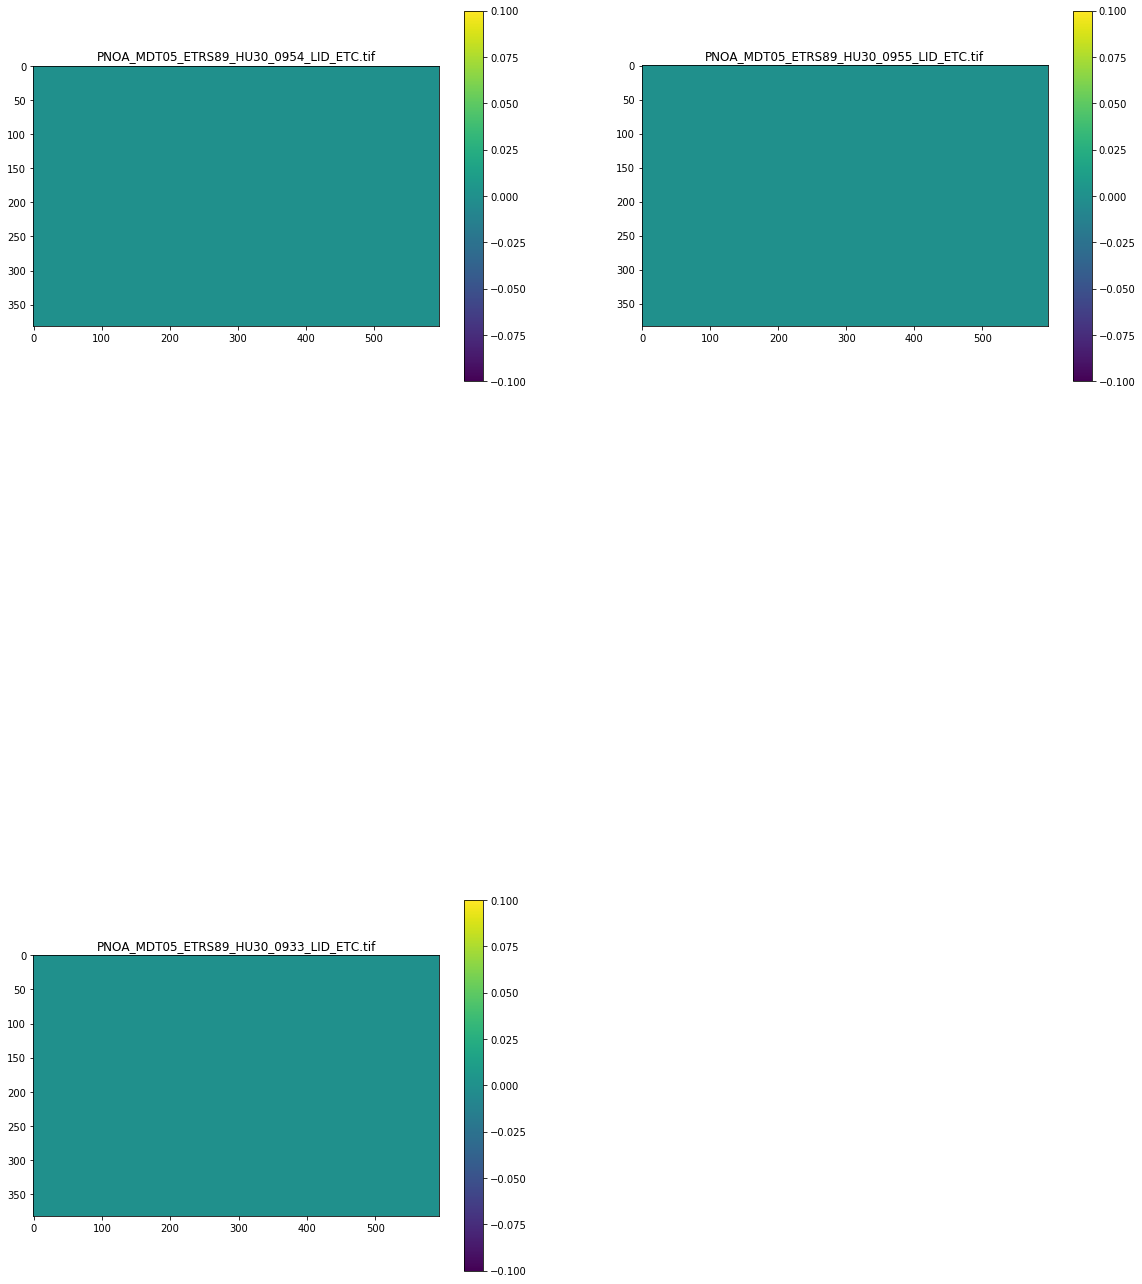

In [48]:
from matplotlib import pyplot as plt

size = len(evapotranspiration_results)
fig, axs = plt.subplots(len(evapotranspiration_results), figsize=(20,30))

i = 1
for item in evapotranspiration_results:
    obj = cos.get_object(item)
    with rasterio.open(obj) as src:
        arr = src.read(1, out_shape=(src.height//10, src.width//10))
        plt.subplot(1 + (size-1)/2, 2, i)
        plt.gca().set_title(item)
        plt.imshow(arr)
        plt.colorbar(shrink=0.5)
        i += 1

plt.show()